#  A Journey Through Titanic
        - https://www.kaggle.com/c/titanic
        
### 1. Data Understanding
        - 1.1 Data Visualization

### 2. Data Preprocessing
        - 2.1 Missing Values
        - 2.2 Dummy Encoding     
        
### 3. Feature  Engineering
        - 3.1 Titles
        - 3.2 Family Size
        - 3.3 Prepare for Modeling

### 4. Data Modeling
        - 4.1 k Nearest Neighbor
        - 4.2 Decision Tree
        - 4.3 Logistic Regression
        - 4.4 Random Forest
        - 4.5 Gradient Boosting
        - 4.6 Model Ensemble

In [2]:
# Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

# Machine Learning
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import majority_vote_classifier as mvc

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

import warnings
warnings.filterwarnings("ignore")

### 1. Data Understanding

In [3]:
# Import Data
train = pd.read_csv('train.csv', na_values=[' '])
test = pd.read_csv('test.csv', na_values=[' ']) 

# Combine train and test (train: 0-890, test: 891-1308)
df = train.append(test, ignore_index=True)
'''
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
'''
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
# Prepare for Visualization
train["class"] = train.Pclass.map({1: "First", 2: "Second", 3: "Third"})
train["embark_town"] = train.Embarked.map({"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})
train["alive"] = train.Survived.map({0: "no", 1: "yes"})
train["alone"] = (train.Parch + train.SibSp).astype(bool).map({False: "Alone", True: "Not Alone"})

#### 1.1 Summary statistics

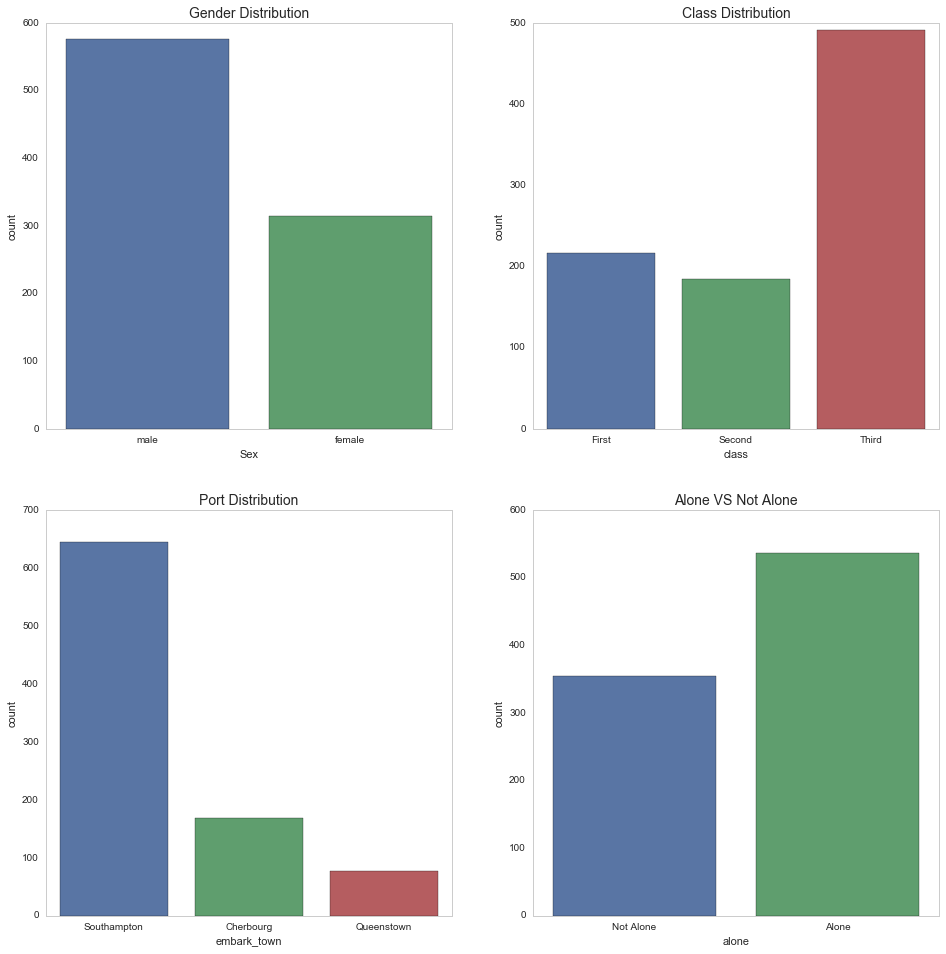

In [5]:
fig=plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
sns.countplot('Sex', data=train)
ax1.set_title("Gender Distribution", fontsize = 14)

ax2 = fig.add_subplot(222)
sns.countplot('class', data=train, order=["First", "Second", "Third"])
ax2.set_title("Class Distribution", fontsize = 14)

ax3 = fig.add_subplot(223)
sns.countplot('embark_town', data=train)
ax3.set_title("Port Distribution", fontsize = 14)


ax4 = fig.add_subplot(224)
sns.countplot('alone', data=train)
ax4.set_title("Alone VS Not Alone", fontsize = 14)

#### 1.2 Survival rate 

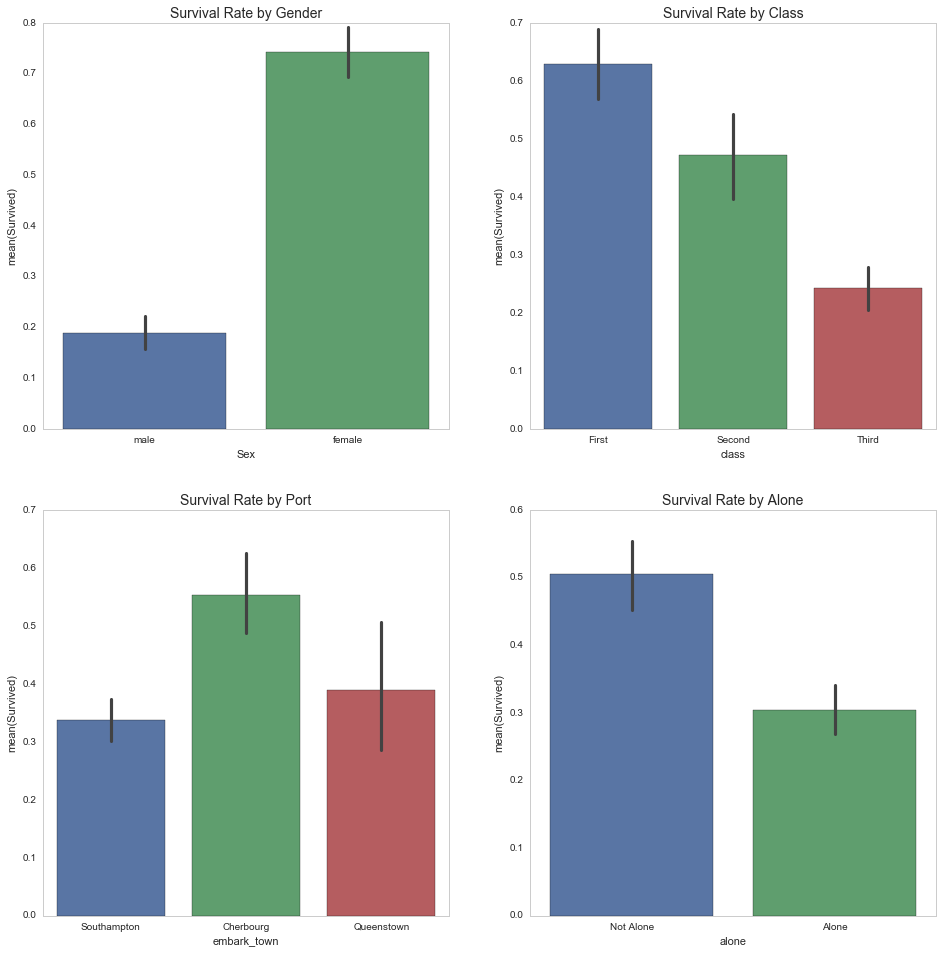

In [6]:
fig=plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
sns.barplot(x="Sex", y="Survived", data=train)
ax1.set_title("Survival Rate by Gender", fontsize = 14)

ax2 = fig.add_subplot(222)
sns.barplot(x="class", y="Survived", data=train, order=["First", "Second", "Third"])
ax2.set_title("Survival Rate by Class", fontsize = 14)

ax3 = fig.add_subplot(223)
sns.barplot(x="embark_town", y="Survived", data=train)
ax3.set_title("Survival Rate by Port", fontsize = 14)


ax4 = fig.add_subplot(224)
sns.barplot(x="alone", y="Survived", data=train)
ax4.set_title("Survival Rate by Alone", fontsize = 14)

#### Why passengers from Cherbourg has the highest survival rate?

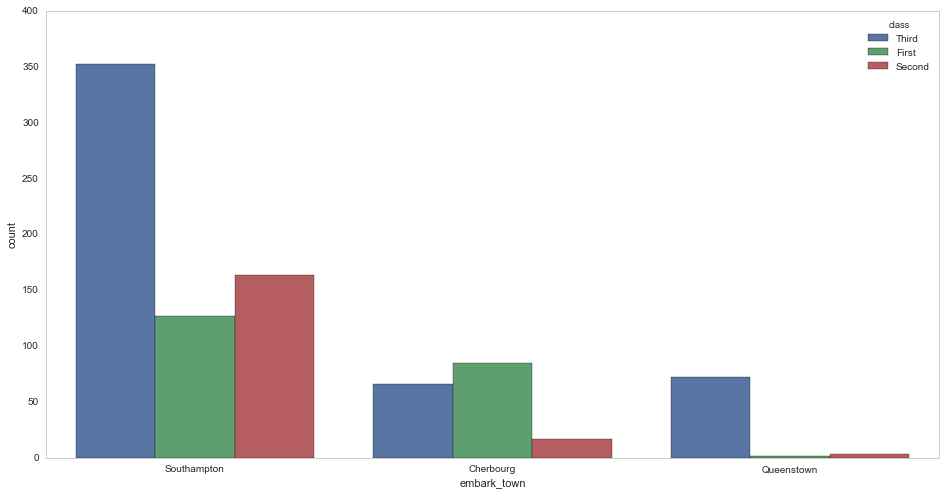

In [7]:
fig=plt.figure(figsize=(16,8))
sns.countplot(x="embark_town", hue="class", data=train)

#### Why passengers with companies have a higher survival rate?

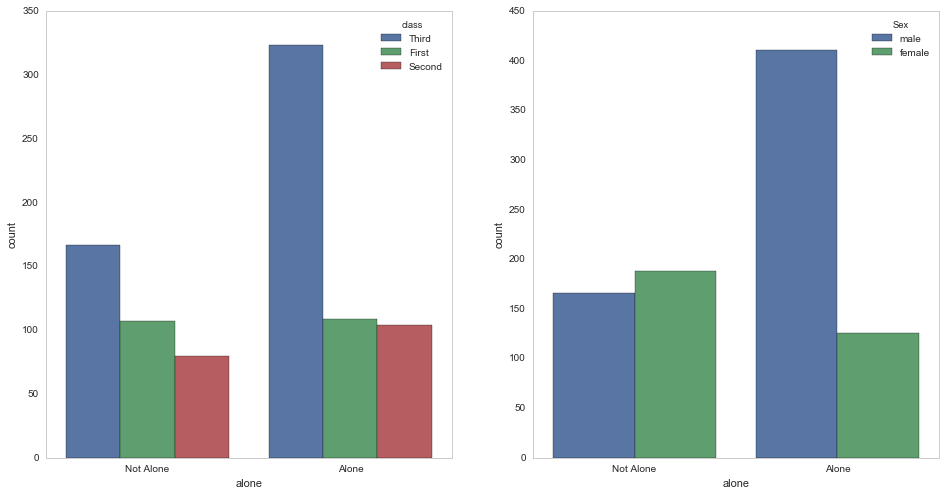

In [8]:
fig=plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
sns.countplot(x="alone", hue="class", data=train)
ax1 = fig.add_subplot(122)
sns.countplot(x="alone", hue="Sex", data=train)

#### How did class and gender affect the survival rate together ?

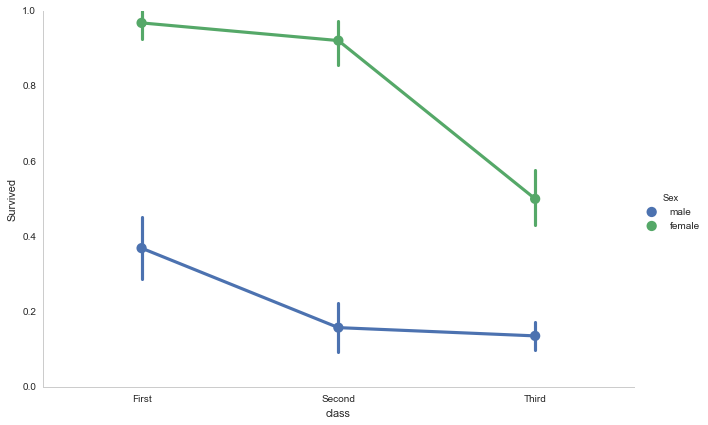

In [10]:
sns.factorplot("class", "Survived", data=train, hue="Sex", size=6, aspect=1.5, 
               order=["First", "Second", "Third"]).set(ylim=(0, 1))

#### How did age affect survival rate?

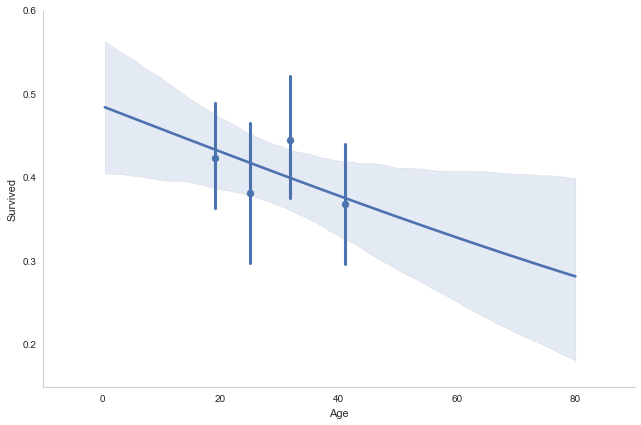

In [11]:
# Plot age and survival with observations grouped into discrete bin
sns.lmplot("Age", "Survived", train, size=6, aspect=1.5, logistic=True, x_bins=4, truncate=True);

#### How did age interact with gender?

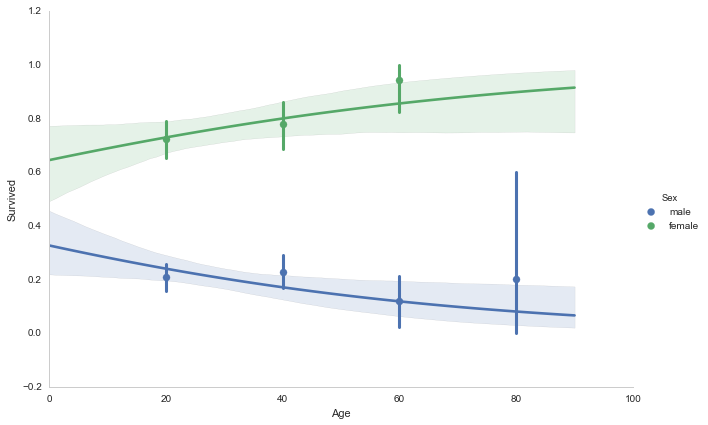

In [14]:
age_bins = age_bins = [20, 40, 60, 80]
sns.lmplot("Age", "Survived", train, hue="Sex", size=6, aspect=1.5, 
           x_bins=age_bins, logistic=True).set(xlim=(0, 100));

### 2. Data Preprocessing

#### 2.1 Handle Missing Values
    - 80% values in Cabin are missing. In this case, I can re-code them as "1: present" and "0: missing".
    - Embarked has 2 missing and Fare has 1. Let's fill in them with mode and median.
    - Age has 263 missing values. In this data, age is very important variable so let's not mess with it first.

In [15]:
df.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [16]:
# Embarked: fill with the mode 'S'
# Fair: fill with median 14.4542
# Cabin: 1: present,  0: missing

df.Embarked = df.Embarked.fillna("S")
df.Fare = df.Fare.fillna(df.Fare.median())
df.Cabin = df.Cabin.map(lambda x: 1 if type(x) == str else 0)

#### 2.2 Dummy Encoding
    - Sex, Passenger Class and Port of Embarkation are categorical variables
    - One-hot dummy encoding seems to be a good choice here.
    - However, I will create several more categorical variables in the Feature Engineering part. Let's do it later.

### 3. Feature Engineering

#### 3.1 Titles

In [17]:
# Take a look at passenger names
train.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [18]:
# Process title using regular expression
df['Title'] = df.Name.str.extract('(\w+\.)', expand=False)
df['Title'].value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Dr.            8
Rev.           8
Col.           4
Major.         2
Ms.            2
Mlle.          2
Jonkheer.      1
Countess.      1
Capt.          1
Don.           1
Lady.          1
Mme.           1
Sir.           1
Dona.          1
Name: Title, dtype: int64

In [19]:
# Replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don.', 'Major.', 'Capt.', 'Jonkheer.', 'Rev.', 'Col.', 'Sir.']:
        return 'Mr.'
    elif title in ['Countess.', 'Mme.', 'Lady.']:
        return 'Mrs.'
    elif title in ['Mlle.', 'Ms.', 'Dona.']:
        return 'Miss.'
    elif title =='Dr.':
        if x['Sex']=='Male':
            return 'Mr.'
        else:
            return 'Mrs.'
    else:
        return title
    
df['Title']=df.apply(replace_titles, axis=1)

In [20]:
df['Title'].value_counts()#.plot(kind='bar')

Mr.        775
Miss.      265
Mrs.       208
Master.     61
Name: Title, dtype: int64

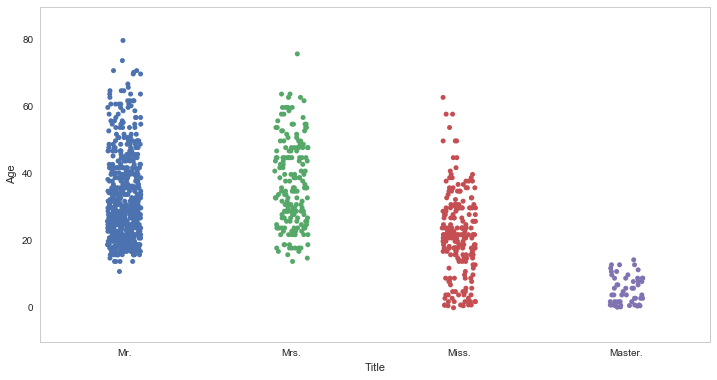

In [21]:
plt.figure(figsize=(12,6))
sns.stripplot(x="Title", y="Age", jitter=True, data=df);

In [22]:
# Now I can fill in missing ages based on titles
df.Age= df.groupby('Title').transform(lambda group: group.fillna(group.median()))

#### 3.2 Family size

In [23]:
# Create a new fature "Family Size"
df['Family_Size'] = df.SibSp + df.Parch

In [24]:
df.Family_Size.value_counts()

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: Family_Size, dtype: int64

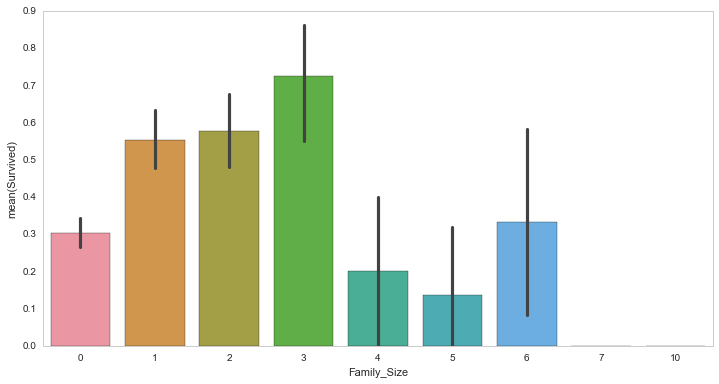

In [25]:
plt.figure(figsize=(12,6))
sns.barplot(x="Family_Size", y="Survived", data=df)

#### 3.3  Prepare for modeling

In [26]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,22.0,0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.,1
1,38.0,1,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.,1
2,26.0,0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.,0
3,35.0,1,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.,1
4,35.0,0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.,0


In [27]:
# One-hot dummy encoding for categorical variables
# Min-Max Scalar for continuous variables

df.Pclass = df.Pclass.astype('category')
df.Family_Size = df.Family_Size.astype('category')

conts = ['Age', 'Fare']
remain = ['Cabin', 'PassengerId', 'Survived']
cats = ['Embarked', 'Title', 'Pclass', 'Family_Size', 'Sex']

dummies = pd.get_dummies(df[cats])
normalized = MinMaxScaler().fit(df[conts]).transform(df[conts])
normalized = pd.DataFrame(normalized,columns=conts)

df_new = pd.concat((dummies, normalized, df[remain]),axis=1)
df_new.head()

,Embarked_C,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Pclass_1,Pclass_2,Pclass_3,...,Family_Size_6,Family_Size_7,Family_Size_10,Sex_female,Sex_male,Age,Fare,Cabin,PassengerId,Survived
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.273456,0.014151,0,1,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.473882,0.139136,1,2,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.323563,0.015469,0,3,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.436302,0.103644,1,4,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.436302,0.015713,0,5,0.0


In [28]:
# Split train and test back
df_train = df_new.iloc[0:891]
df_test = df_new.iloc[891:]

# Seperate 'Survival'
y = df_train.Survived.values

# Drop Passenger Id
df_train.drop(['PassengerId', 'Survived'], inplace = True, axis=1)
df_test.drop(['PassengerId', 'Survived'], inplace = True, axis=1)
x = df_train.values

In [29]:
del train, test, df, dummies, normalized

### 4. Data Modeling

In [30]:
# 80% - 20% train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=55)

#### 4.1 k Nearest Neighbor

In [31]:
# KNN pipeline
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

# Specify values for number of neighbors to tune
param_grid = [{'clf__n_neighbors': np.arange(1, 15, 1)}]

# Perform grid search cross validation on the parameters listed in param_grid
gs = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring='accuracy', cv=10)

# Fit the cross validated KNN to the training dataset and view the parameters of the best model
gs.fit(x_train, y_train)

# Get the best parameters and model scores
best_KNN_params = gs.best_params_
print("Optimal KNN parameters are: ", best_KNN_params)
knn_cv_scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=10)
print("Average KNN Accuracy in cross validation: %.3f +/- %.3f" % (np.mean(knn_cv_scores), np.std(knn_cv_scores)))
knn_test_scores = accuracy_score(gs.predict(x_test), y_test)
print("KNN Accuracy in hold-out test Set: %0.3f" % (knn_test_scores))

Optimal KNN parameters are:  {'clf__n_neighbors': 14}
Average KNN Accuracy in cross validation: 0.825 +/- 0.039
KNN Accuracy in hold-out test Set: 0.788


In [32]:
# Build KNN with optimized parameters
classifier1 = KNeighborsClassifier(n_neighbors=gs.best_params_['clf__n_neighbors'])

#### 4.2 Decision Tree

In [33]:
# Decision Tree Pipline
pip_dt = Pipeline([('clf', DecisionTreeClassifier())])

# Specify values for number of neighbors to tune

param_grid = [{'clf__criterion': ['entropy','gini'], 'clf__max_depth': np.arange(1, 20, 2),
               'clf__max_features': np.arange(1, 23, 2),
               'clf__min_samples_split': np.arange(2, 10, 2)}]

# Perform grid search cross validation on the parameters listed in param_grid
gs = GridSearchCV(estimator=pip_dt, param_grid=param_grid, scoring='accuracy', cv=10)

# Fit the cross validated KNN to the training dataset and view the parameters of the best model
gs.fit(x_train, y_train)

# Get the best parameters and model scores
best_DT_params = gs.best_params_
print("Optimal decision tree parameters are: ", best_DT_params)
dt_cv_scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=10)
print("Average Decision tree accuracy in cross validation: %.3f +/- %.3f" % (np.mean(dt_cv_scores), np.std(dt_cv_scores)))
dt_test_scores = accuracy_score(gs.predict(x_test), y_test)
print("Decision tree accuracy in hold-out test Set: %0.3f" % (dt_test_scores))

Optimal decision tree parameters are:  {'clf__max_features': 17, 'clf__criterion': 'gini', 'clf__min_samples_split': 8, 'clf__max_depth': 5}
Average Decision tree accuracy in cross validation: 0.823 +/- 0.064
Decision tree accuracy in hold-out test Set: 0.816


In [34]:
# Build DT with optimized parameters
classifier2 = DecisionTreeClassifier(criterion=gs.best_params_['clf__criterion'], 
                                     max_depth=gs.best_params_['clf__max_depth'],
                                     max_features= gs.best_params_['clf__max_features'], 
                                     min_samples_split= gs.best_params_['clf__min_samples_split'])

#### 4.3 Logistic Regression

In [42]:
# LG pipeline
pipe_lg = Pipeline([('clf', LogisticRegression())])

# Specify values for the parameter c, which determines how large the margin is for the SVM
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# List the hyperparameters to tune for the SVM
param_grid = [{'clf__penalty': ['l1', 'l2'], 'clf__C': param_range}]

# Perform grid search cross validation on the parameters listed in param_grid
gs = GridSearchCV(estimator=pipe_lg, param_grid=param_grid, scoring='accuracy', cv=10)

# Fit the cross validated SVM to the training dataset and view the parameters of the best model
gs.fit(x_train, y_train)

best_LG_params = gs.best_params_
print("Optimal logistic regression parameters are: ", best_LG_params)
lg_cv_scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=10)
print("Average logistic regression accuracy in cross validation: %.3f +/- %.3f" % (np.mean(lg_cv_scores), np.std(lg_cv_scores)))
lg_test_scores = accuracy_score(gs.predict(x_test), y_test)
print("Logistic regression accuracy in hold-out test Set: %0.3f" % (lg_test_scores))

Optimal logistic regression parameters are:  {'clf__C': 1.0, 'clf__penalty': 'l2'}
Average logistic regression accuracy in cross validation: 0.832 +/- 0.052
Logistic regression accuracy in hold-out test Set: 0.827


In [43]:
#Build LG with optimized parameters 
classifier3 = LogisticRegression(C=gs.best_params_['clf__C'], penalty=gs.best_params_['clf__penalty'])

#### 4.4 Random Forest

In [37]:
# RF pipeline
pipe_rf = Pipeline([('clf', RandomForestClassifier())])

# Specify values for number of neighbors to tune

param_grid = [{'clf__criterion': ['entropy','gini'], 'clf__max_depth': [3, 5, 7, 9, 11],
               'clf__max_features': [5, 10, 15, 20],
               'clf__n_estimators': [50, 100, 150, 200]}]

# Perform grid search cross validation on the parameters listed in param_grid
gs = GridSearchCV(estimator=pipe_rf, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=4)

# Fit the cross validated KNN to the training dataset and view the parameters of the best model
gs.fit(x_train, y_train)

# Get the best parameters and model scores
best_RF_params = gs.best_params_
print("Optimal random forest parameters are: ", best_RF_params)
rf_cv_scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=10)
print("Average random forest accuracy in cross validation: %.3f +/- %.3f" % (np.mean(rf_cv_scores), np.std(rf_cv_scores)))
rf_test_scores = accuracy_score(gs.predict(x_test), y_test)
print("Random forest accuracy in hold-out test Set: %0.3f" % (rf_test_scores))

Optimal random forest parameters are:  {'clf__n_estimators': 50, 'clf__max_features': 20, 'clf__criterion': 'entropy', 'clf__max_depth': 9}
Average random forest accuracy in cross validation: 0.829 +/- 0.051
Random forest accuracy in hold-out test Set: 0.810


In [38]:
# Build RF with optimized parameters
classifier4 = RandomForestClassifier(n_estimators=gs.best_params_['clf__n_estimators'],
                                     criterion=gs.best_params_['clf__criterion'], 
                                     max_depth=gs.best_params_['clf__max_depth'],
                                     max_features= gs.best_params_['clf__max_features'])

#### 4.5 Gradient Boosting

In [39]:
# GB pipeline
pipe_gb = Pipeline([('clf', GradientBoostingClassifier())])

# Specify values for number of neighbors to tune

param_range = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
param_grid = [{'clf__loss': ['deviance','exponential'], 'clf__learning_rate': param_range,
               'clf__max_depth': [3, 5, 7, 9, 11], 
               'clf__n_estimators': [100, 150, 200, 250]}]

# Perform grid search cross validation on the parameters listed in param_grid
gs = GridSearchCV(estimator=pipe_gb, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=4)

# Fit the cross validated KNN to the training dataset and view the parameters of the best model
gs.fit(x_train, y_train)

# Get the best parameters and model scores
best_GB_params = gs.best_params_
print("Optimal gradient boosting parameters are: ", best_GB_params)
gb_cv_scores = cross_val_score(gs, x_train, y_train, scoring='accuracy', cv=10)
print("Average gradient boosting accuracy in cross validation: %.3f +/- %.3f" % (np.mean(gb_cv_scores), np.std(gb_cv_scores)))
gb_test_scores = accuracy_score(gs.predict(x_test), y_test)
print("Gradient boosting accuracy in hold-out test Set: %0.3f" % (gb_test_scores))

Optimal gradient boosting parameters are:  {'clf__n_estimators': 200, 'clf__learning_rate': 0.1, 'clf__loss': 'exponential', 'clf__max_depth': 3}
Average gradient boosting accuracy in cross validation: 0.819 +/- 0.045
Gradient boosting accuracy in hold-out test Set: 0.832


In [40]:
# Build GB with optimized parameters
classifier5 = GradientBoostingClassifier(n_estimators=gs.best_params_['clf__n_estimators'],
                                     loss=gs.best_params_['clf__loss'], 
                                     max_depth=gs.best_params_['clf__max_depth'],
                                     learning_rate= gs.best_params_['clf__learning_rate'])

#### Visualiza the performance of each model

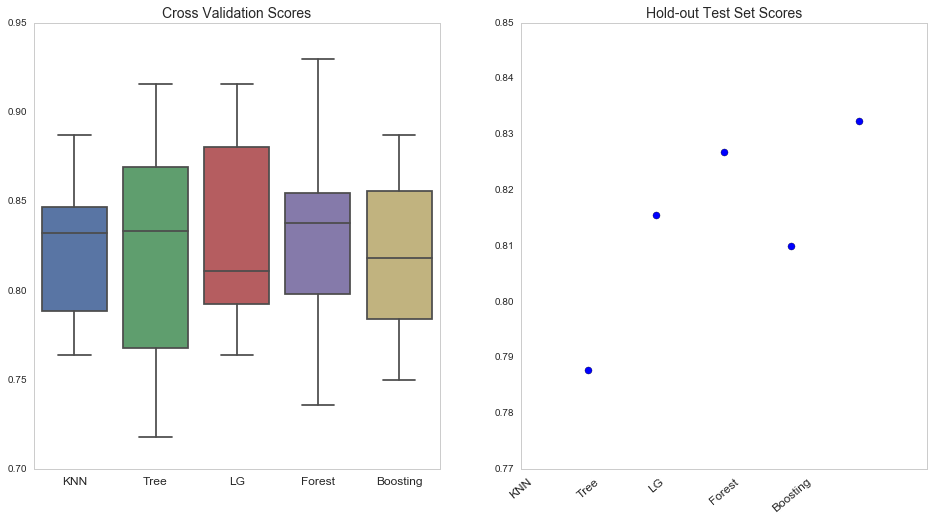

In [102]:
Models = ['KNN', 'Tree', 'LG', 'Forest', "Boosting"]
cv_score = [knn_cv_scores, dt_cv_scores, lg_cv_scores, rf_cv_scores, gb_cv_scores]
test_score = [knn_test_scores, dt_test_scores, lg_test_scores, rf_test_scores, gb_test_scores]

fig=plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
sns.boxplot(x=Models, y=cv_score)
ax1.set_xticklabels(Models, fontsize=12)
ax1.set_title("Cross Validation Scores", fontsize = 14)

ax2 = fig.add_subplot(122)
x = [1,2,3,4,5]
plt.scatter(x, test_score, s=50)
ax2.set_xticklabels(Models, fontsize=12, rotation=40)
ax2.set_title("Hold-out Test Set Scores", fontsize = 14)

#### 4.6 Model Ensemble

In [103]:
# Set labels and build ensemble
clf_labels = ['KNN', 'Decison Tree', 'Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Majority Vote Classifier']
mv_clf = mvc.MajorityVoteClassifier(classifiers=[classifier1, classifier2, classifier3, classifier4, classifier5])

# Check ensemble model performance
mv_clf.fit(x_train, y_train)
ensemble_scores = accuracy_score(mv_clf.predict(x_test), y_test)
print("Ensemble model accuracy in hold-out test Set: %0.3f" % (ensemble_scores))

Ensemble model accuracy in hold-out test Set: 0.827


In [ ]:
"""
mv_clf.fit(x, y)
pred = (mv_clf.predict(df_test)).astype(int)
df = pd.DataFrame({'Survived': pred,'PassengerId': test.PassengerId})
df.to_csv('5_model_ensemble.csv', index = False)
"""

### This ensemble model scored 79.99% on the public leader board, 800th/6100 teams
### 5. Room for Improvement?
    - Stack More Models
    - Interaction Terms
    - Any Suggestions